In [1]:
import string

import numpy as np
import torch
import nltk
from datasets import load_dataset
from gensim.models import Word2Vec, LdaModel, Doc2Vec
from gensim import corpora
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

from utils import find_best_acc_and_threshold, find_best_f1_and_threshold

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/coder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/coder/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/coder/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/coder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Text Similarity using Natural Language Processing

In NLP, one of the fundamental tasks is measuring the similarity between texts. Text similarity, in essence, is the process of quantifying how alike two or more pieces of text are in terms of their content, meaning, or structure.

In this notebook, we will explore the concept of text similarity, which often boils down to understanding the similarity between sentences. 

To demonstrate and experiment with text similarity techniques, we will utilize the [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398) dataset. This dataset is a part of the [GLUE](https://gluebenchmark.com/) (General Language Understanding Evaluation benchmark) and contains pairs of sentences, each associated with a label indicating whether the texts are semantically equivalent.

Let's begin by loading the dataset and taking a closer look at its contents.

In [2]:
dataset = load_dataset("glue", "mrpc")

In [3]:
train_dataset = dataset['train'].with_format('torch')
valid_dataset = dataset['validation'].with_format('torch')
test_dataset = dataset['test'].with_format('torch')

In [4]:
train_dataset.features # show features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [5]:
pd.DataFrame(train_dataset).head()

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",tensor(1),tensor(0)
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,tensor(0),tensor(1)
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",tensor(1),tensor(2)
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",tensor(0),tensor(3)
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,tensor(1),tensor(4)


<AxesSubplot:>

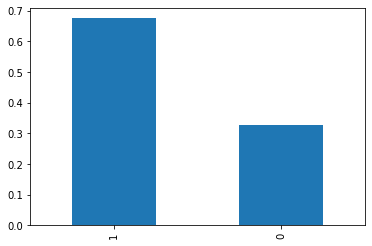

In [6]:
# plot labels distribution as percentage
pd.Series(train_dataset['label'].numpy()).value_counts(normalize=True).plot(kind='bar')

As we can see, the dataset is unbalanced.

### Utils

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

def preprocess_dataset(ds):
    # tokenize
    return ds.map(lambda x: {'sentence1': simple_preprocess(x['sentence1']), 'sentence2': simple_preprocess(x['sentence2'])})

preprocessed_train_dataset = preprocess_dataset(train_dataset)
preprocessed_test_dataset = preprocess_dataset(test_dataset)

In [8]:
def predict(model, ds):
    return model(ds['sentence1'], ds['sentence2'])

def score(labels, scores):
    """
    Calculate the best accuracy and the best F1-score for given labels and scores. 
    The best accuracy is the accuracy when the threshold is chosen to maximize the accuracy.
    Likewise for F1-score.
    
    :param labels: Ground truth labels (0 or 1)
    :param scores: Cosine similarity scores of embeddings
    :return Returns the prediction with the best accuracy
    """
    acc, t1 = find_best_acc_and_threshold(scores, labels, True)
    f1, _, _, t2 = find_best_f1_and_threshold(scores, labels, True)
    print(f'Best Accuracy: {acc:.4f} (threshold={t1:.4f})')
    print(f'Best F1: {f1:.4f} (threshold={t2:.4f})')
    return scores > t1
    
def abs_score(labels, scores):
    acc = accuracy_score(labels, scores)
    f1 = f1_score(labels, scores)
    print(f'Accuracy: {acc:.4f}')
    print(f'F1: {f1:.4f}')
    return scores == 1

preds = {}

## Approaches
### 1 TF-IDF

For this approach let's calculate tf-idf vectors of texts and compare them using cosine similarity. We will use `scikit-learn` and `nltk` for this task.

In [9]:
vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, stop_words=stopwords + list(punctuation))
vectorizer.fit(train_dataset['sentence1'] + train_dataset['sentence2'])

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function word_tokenize at 0x7f0fb7d6db80>)

In [10]:
def tf_idf_model(sentences1, sentences2):
    tf_idf1 = vectorizer.transform(sentences1)
    tf_idf2 = vectorizer.transform(sentences2)
    return torch.tensor(cosine_similarity(tf_idf1, tf_idf2).diagonal())

In [11]:
preds['tfidf'] = predict(tf_idf_model, test_dataset)
preds['tfidf'] = score(test_dataset['label'], preds['tfidf'])

Best Accuracy: 0.7072 (threshold=0.4930)
Best F1: 0.8144 (threshold=0.3834)


For such a simple approach this not too bad. This is going to be our baseline. Let's try to improve.

### 2 BLEU-score
Let's try using BLEU-score as a metric of similarity of two texts. We will use `nltk` for this task.

In [12]:
def bleu_score_model(sentences1, sentences2):
    res = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        res.append(nltk.translate.bleu_score.sentence_bleu([sentence1], sentence2))
    return torch.tensor(res)

In [13]:
preds['bleu'] = predict(bleu_score_model, test_dataset)
preds['bleu'] = score(test_dataset['label'], preds['bleu'])

Best Accuracy: 0.7472 (threshold=0.5129)
Best F1: 0.8283 (threshold=0.5129)


Wow, this trivial approach is better than TF-IDF.

### 3 Word Embeddings: Word2Vec
Let's try to use word embeddings. We will use Word2Vec embeddings from `gensim` and calculate sentence embeddings as an average of word embeddings. Then we will compare sentence embeddings using cosine similarity.

In [14]:
dictionary = corpora.Dictionary(preprocessed_train_dataset['sentence1'] + preprocessed_train_dataset['sentence2'])

In [15]:
word2vec = Word2Vec(preprocessed_train_dataset['sentence1'] + preprocessed_train_dataset['sentence2'], min_count=1, epochs=40).wv

def word2vec_model(sentences1, sentences2):
    res = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        res.append(word2vec.n_similarity(sentence1, sentence2))
    return torch.tensor(res)

In [16]:
preds['word2vec'] = predict(word2vec_model, preprocessed_test_dataset)
preds['word2vec'] = score(test_dataset['label'], preds['word2vec'])

Best Accuracy: 0.6754 (threshold=0.6523)
Best F1: 0.8015 (threshold=0.4268)


Well, this approach turned out worse than our baseline.

### 4 Doc2Vec
This is a logical continuation of the previous approach. We will use Doc2Vec embeddings from `gensim`. Like in the previous approach, we will compare sentence embeddings using cosine similarity.

In [17]:
doc2vec = Doc2Vec(vector_size=100, min_count=1, epochs=100)
tagged_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_train_dataset['sentence1'] + preprocessed_train_dataset['sentence2'])]
doc2vec.build_vocab(tagged_corpus)
doc2vec.train(tagged_corpus, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

def doc2vec_model(sentences1, sentences2):
    res = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        res.append(doc2vec.similarity_unseen_docs(sentence1, sentence2))
    return torch.tensor(res)

In [18]:
preds['doc2vec'] = predict(doc2vec_model, preprocessed_test_dataset)
preds['doc2vec'] = score(test_dataset['label'], preds['doc2vec'])

Best Accuracy: 0.7020 (threshold=0.3946)
Best F1: 0.8049 (threshold=0.1942)


Well, we get results comparable to the simplest baseline tf-idf.

### 5 Latent Dirichlet Allocation
Let's try LDA. The idea is to represent each sentence as a distribution over topics and then compare these distributions using cosine distance. We will use `gensim` for this task. We will use 10 topics.

In [19]:
corpus1 = [dictionary.doc2bow(sentence) for sentence in preprocessed_train_dataset['sentence1']]
corpus2 = [dictionary.doc2bow(sentence) for sentence in preprocessed_train_dataset['sentence2']]
train_corpus = corpus1 + corpus2
lda = LdaModel(train_corpus, num_topics=10, id2word=dictionary)

In [20]:
def lda_model(sentences1, sentences2):
    res = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        # to bow
        bow1 = dictionary.doc2bow(sentence1)
        bow2 = dictionary.doc2bow(sentence2)
        # to topic distribution
        emb1 = lda.get_document_topics(bow1, minimum_probability=0)
        emb2 = lda.get_document_topics(bow2, minimum_probability=0)
        # to numpy array
        emb1 = np.array(emb1)[:, 1]
        emb2 = np.array(emb2)[:, 1]
        # cosine similarity
        res.append(cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0])
    return torch.tensor(res)

In [21]:
preds['lda'] = predict(lda_model, preprocessed_test_dataset)
preds['lda'] = score(test_dataset['label'], preds['lda'])

Best Accuracy: 0.6684 (threshold=0.1079)
Best F1: 0.7990 (threshold=0.0163)


We got a result similar to the previous approaches.

Why did this happen? And why have word2vec, doc2vec and LDA do worse than simple tf-idf? I think the reason is in the dataset specifics. The dataset contains *paraphrased* sentences, therefore the sentences are very similar. This means that the average of word embeddings of two sentences will be very similar. To understand the difference between the sentences, we must look at the context of the sentence and specific words that carry a lot of information (like numbers, names, dates, etc.). 

So basically I think that `word2vec`, `doc2vec` and `LDA` are better suited for tasks where the sentences are not very similar. For example, for determining whether texts share the same topic.

## Transformer-based approaches
To better capture the context let's try to use transformer-based approaches. Transformers are a good choice because they are able to capture the context of the sentence. We will use `transformers` and `sentence-transformers` libraries for this task.
### 6 BERT Classifier

Let's try using the BERT model. We will use a `BERTClassifier` for two labels ("texts not equivalent" and "texts equivalent"). We will put both sentences into the model (using the `huggingface` tokenizer) simultaneously. The output of the model will be two neurons for our labels, and we pick the one with the higher value to be the predicted label.

![BERTClassifier setup](https://alexkovrigin.me/data/mermaid-diagram-2023-09-15-203138.png)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

First, let's evaluate the raw model.

In [26]:
preds['bert'] = torch.tensor(trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=1))
preds['bert'] = abs_score(test_dataset['label'], preds['bert'])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy: 0.3351
F1: 0.0000


Well, the weights on the last two neurons have not been initialized... Let's try to get a sensible result by fine-tuning the model.

In [27]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=690, training_loss=0.3321452182272206, metrics={'train_runtime': 124.6824, 'train_samples_per_second': 88.256, 'train_steps_per_second': 5.534, 'total_flos': 430733353175520.0, 'train_loss': 0.3321452182272206, 'epoch': 3.0})

In [28]:
preds['bert'] = torch.tensor(trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=1))
preds['bert'] = abs_score(test_dataset['label'], preds['bert'])

Accuracy: 0.8267
F1: 0.8758


The result has improved immensely, making this approach better than any other approach we tried so far!

### 7 Sentence Transformer Embeddings
Rather logically, we can also generate embeddings using transformers. For our purposes, we have positive and negative pairs, therefore we can use a Siamese network with contrastive loss. We will use the `sentence-transformers` library for this task.

![Sentence Transformer setup](https://alexkovrigin.me/data/mermaid-diagram-2023-09-15-203213.png)

Sentence Transformers library is a powerful tool for NLP tasks, including sentence similarity. Furthermore, it has a great interface for fine-tuning models on custom datasets. We will use it to fine-tune a model on the MRPC dataset. We will use the `all-mpnet-base-v2` model and cosine similarity contrastive loss.

In [29]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

First, let's evaluate the raw model.

In [30]:
def st_model(sentences1, sentences2):
    model.eval()
    res = []
    embeddings = model.encode(sentences1 + sentences2, show_progress_bar=True)
    for emb1, emb2 in zip(embeddings[:len(sentences1)], embeddings[len(sentences1):]):
        res.append(cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0])
    return torch.tensor(res)

In [31]:
# evaluate acc and f1 on sentence transformer model
model.eval()
preds['sentence_transformer'] = predict(st_model, test_dataset)
preds['sentence_transformer'] = score(test_dataset['label'], preds['sentence_transformer'])

Batches: 100%|██████████| 108/108 [00:01<00:00, 88.31it/s]


Best Accuracy: 0.7507 (threshold=0.6873)
Best F1: 0.8314 (threshold=0.6384)


This is fine. Let's see what happens when we fine-tune the model.

In [32]:
train_examples = []

for example in train_dataset:
  train_examples.append(InputExample(texts=[example['sentence1'], example['sentence2']], label=float(example['label'])))

In [33]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)
train_loss = losses.CosineSimilarityLoss(model=model)
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data
evaluator = BinaryClassificationEvaluator(valid_dataset['sentence1'], valid_dataset['sentence2'], valid_dataset['label'])

In [34]:
model.train()
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          evaluator=evaluator) 

Epoch: 100%|██████████| 10/10 [01:30<00:00,  9.10s/it]


In [35]:
# evaluate acc and f1 on sentence transformer model
model.eval()
preds['sentence_transformer'] = predict(st_model, test_dataset)
preds['sentence_transformer'] = score(test_dataset['label'], preds['sentence_transformer'])

Batches: 100%|██████████| 108/108 [00:01<00:00, 84.97it/s]


Best Accuracy: 0.8168 (threshold=0.5908)
Best F1: 0.8678 (threshold=0.5908)


Indeed, fine-tuning improved the result.

Actually, the highest score overall on the [sentence similarity leaderboard](https://huggingface.co/spaces/mteb/leaderboard) is achieved by a similar (but larger) model [BAAI/bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5).

## Conclusion

We tried several approaches to the text similarity task. First, we tried simple approaches like tf-idf, BLEU-score as baselines. Then we tried word embeddings (Word2Vec, Doc2Vec) and LDA. Finally, we tried transformer-based approaches (BERT classifier and Sentence Transformer Embeddings). 

We saw that out of these models transformer-based approaches were the best for this task.

However, the other tried approaches could still be valuable, since they can be used together with other approaches. For example, we can use them to filter out dissimilar sentences and then use transformers to compare the remaining sentences.

Lastly, we can take a look at the predictions of our models for some examples from the test dataset:

In [36]:
df = pd.DataFrame(test_dataset)
df['label'] = test_dataset['label'].numpy().astype(bool)
df.drop('idx', inplace=True, axis=1)
df['tfidf'] = preds['tfidf'].numpy()
df['bleu'] = preds['bleu'].numpy()
df['word2vec'] = preds['word2vec'].numpy()
df['doc2vec'] = preds['doc2vec'].numpy()
df['lda'] = preds['lda'].numpy()
df['bert'] = preds['bert'].numpy()
df['sentence_transformer'] = preds['sentence_transformer'].numpy()
df.head(10)

,sentence1,sentence2,label,tfidf,bleu,word2vec,doc2vec,lda,bert,sentence_transformer
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,True,True,True,True,True,True,True,True
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,True,True,True,True,True,True,True,True
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,True,True,True,True,True,True,True,True
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,False,True,True,True,False,True,True,False
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,False,True,False,True,False,False,False,False
5,The settling companies would also assign their...,"Under the agreement , the settling companies w...",True,True,True,True,True,True,True,True
6,Air Commodore Quaife said the Hornets remained...,Air Commodore John Quaife said the security op...,False,False,False,False,True,True,False,False
7,A Washington County man may have the countys f...,The countys first and only human case of West ...,True,True,False,True,False,True,False,False
8,Moseley and a senior aide delivered their summ...,General Moseley and a senior aide presented th...,True,True,True,True,True,True,True,True
9,The broader Standard & Poor 's 500 Index < .SP...,The technology-laced Nasdaq Composite Index .I...,False,False,False,True,False,True,False,False


## Other possible approaches
Here are some ideas for other possible approaches:
- [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)
- [LSA](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
- [Soft Cosine Similarity](https://radimrehurek.com/gensim/similarities/soft_cosine_tutorial.html)
- [FastText](https://fasttext.cc/)

## References
- [Sentence Transformers](https://www.sbert.net/)
- [HuggingFace Transformers](https://huggingface.co/transformers/)
- [Gensim](https://radimrehurek.com/gensim/)
- [NLTK](https://www.nltk.org/)
- [Scikit-learn](https://scikit-learn.org/stable/)
- [Sentence Similarity Evaluation](https://huggingface.co/spaces/mteb/leaderboard)
- [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398)
- [GLUE](https://gluebenchmark.com/)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084)
- [BAAI/bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5)
- [Fine-tuning a model with the Trainer API](https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt)
- [HuggingFace Sentence Similarity](https://huggingface.co/tasks/sentence-similarity)